In [2]:
import db_access as dba

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
import pylab as plb
plb.rcParams['pdf.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


In [3]:
fly_db = dba.get_db()

In [133]:
expmnt = fly_db[610]['experiments'].values()[0]
#expmnt = fly_db[579]['experiments'].values()[0]

KeyError: 610

In [130]:
expmnt['tiff_data'].keys()

[u'axon_framebase', u'frame_idx', u'images']

In [131]:
img = np.array(expmnt['tiff_data']['images'][0])

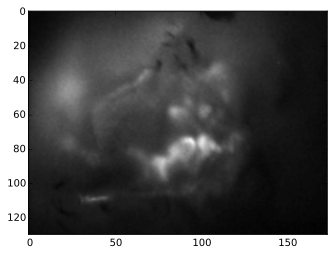

In [132]:
imshow(img,cmap = cm.gray)

In [125]:
imgs = np.array(expmnt['tiff_data']['images'])

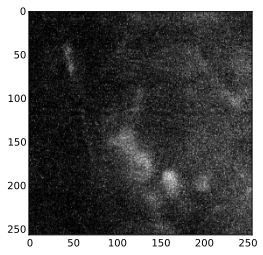

In [12]:
imshow(imgs[5],cmap = cm.gray)

In [223]:
#subplot(2,1,1)
#plot(expmnt['axon_data']['Ph1'][500000:600000:10])
#subplot(2,1,2)
#plot(expmnt['axon_data']['LeftWing'][500000:600000:10])

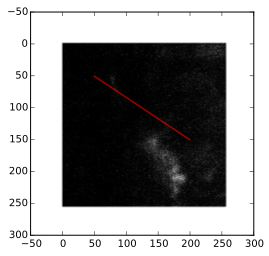

In [185]:
#show an image of where the profile is taken
from skimage import measure
import cv2
fnum = 5000
figure()

#p1 = {'x':20,'y':50}
#p2 = {'x':170,'y':130}
p1 = {'x':50,'y':50}
p2 = {'x':200,'y':150}

v1 = np.array([p1['x']-p2['x'],p1['y']-p2['y'],0])
v2 = [0,0,-1]
nv = np.cross(v2,v1)/np.linalg.norm(np.cross(v2,v1))

img = expmnt['tiff_data']['images'][fnum+4000]
three_chan = dstack([img,img,img])
imshow(img**1.9,cmap = cm.gray)
plot([p1['x'],p2['x']],[p1['y'],p2['y']],color = 'r',linewidth = 1,alpha = 0.5)
plot([p1['x']+nv[0],p2['x']+nv[0]],[p1['y']+nv[1],p2['y']+nv[1]],color = 'r',linewidth = 1,alpha = 0.5)

In [186]:
def gaussian(x, mean = 20, sd = 20):
    """ return a gaussian function"""
    return 1.0/(sd*np.sqrt(2*np.pi))*np.exp(-(x - mean)**2/(2*sd**2))

def sumgau(x,s1,m1,sd1,s2,m2,sd2):
    """ return a sum of two gaussians"""
    return s1*gaussian(x,mean=m1,sd=sd1) + s2*gaussian(x,mean=m2,sd=sd2) 

In [187]:
### fit a sum of two gaussians to the profile extracted from a series of frames
"""
from scipy import optimize
plist = list()
nsamp = 4000
p0 = [1,10,10,1,120,20]
for img,i in zip(expmnt['tiff_data']['images'][fnum:fnum+nsamp],linspace(0,1,nsamp)):
    color = cm.jet(i)
    #img = expmnt['tiff_data']['images'][fnum]
    three_chan = dstack([img,img,img])
    y = measure.profile_line(cv2.pyrMeanShiftFiltering(three_chan,10,80),(50,20),(120,150),linewidth = 13)[:,0]
    x = np.arange(0,len(y))
    #plot(x,y,color = color)
    try:
        pfit = optimize.curve_fit(sumgau,x,y-np.min(y),p0)
        p0 = pfit[0]
        plist.append(p0)
    except RuntimeError:
        plist.append([np.nan]*6)
    #plot(x,sumgau(x,*pfit[0])+np.min(y),color = color,lw = 3,alpha = 0.5)
""";

In [188]:
# select the flight bout
timemask = ((np.array(expmnt['tiff_data']['axon_framebase']['times'])>8.5) & ((np.array(expmnt['tiff_data']['axon_framebase']['times'])<16.0)))

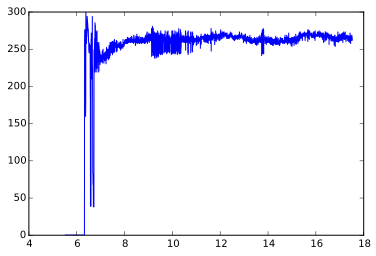

In [189]:
plot(expmnt['tiff_data']['axon_framebase']['times'],array(expmnt['tiff_data']['axon_framebase']['wb_frequency']))

In [190]:
# start and stop of the selected bout
sta = np.array(expmnt['tiff_data']['axon_framebase']['times'])[timemask][0]
stp = np.array(expmnt['tiff_data']['axon_framebase']['times'])[timemask][-1]

In [191]:
# mask to pull out selected interval from axon data
axon_mask = (np.array(expmnt['axon_data']['times']) >sta) & (np.array(expmnt['axon_data']['times']) <stp)

In [192]:
# select the time and hutchen signal from the axon data
masked_rwing = np.array(expmnt['axon_data']['LeftWing'])[axon_mask] # the wb analizer is wired up incorrectly
masked_times = np.array(expmnt['axon_data']['times'])[axon_mask]

In [207]:
# trigger on the hutchens and then constuct pkidxs an array of where the wingstroke
# peaked (with respect to the indexes of the selected axon signal) 
import flylib
wtrigs = flylib.idx_by_thresh(masked_rwing,-0.3)
pkidxs = list()
for trig in wtrigs:
    pkidxs.append(np.argmax(masked_rwing[trig]) + trig[0])
pkidxs = np.array(pkidxs)

In [208]:
# calculate the voltage at hutchen peak
pkvals = masked_rwing[pkidxs]

In [209]:
# find the quartile levels
b1 = np.percentile(pkvals,75)
b2 = np.percentile(pkvals,50)
b3 = np.percentile(pkvals,25)

In [210]:
# mask on wb indexes that select the four groups
wb_mask_75_100 = pkvals>b1
wb_mask_50_75 = (pkvals>b2) & (pkvals<b1)
wb_mask_25_50 = (pkvals>b3) & (pkvals<b2)
wb_mask_0_25 = (pkvals<b3)

In [211]:
# lists of wingbeat indecies for the bottom and top quartile wingstrokes
wtrigs_75_100 = [wtrigs[i] for i in where(wb_mask_75_100)[0]]
wtrigs_0_25 = [wtrigs[i] for i in where(wb_mask_0_25)[0]]

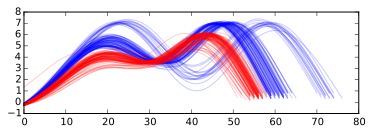

In [212]:
import random
subplot(2,1,1)
[plot(masked_rwing[x],color = 'b', alpha = 0.2) for x in random.sample(wtrigs_75_100,100)]
#gca().set_xbound(0,70)
#subplot(2,1,2)
[plot(masked_rwing[x],color = 'r', alpha = 0.2) for x in random.sample(wtrigs_0_25,100)]
#gca().set_xbound(0,70);

In [213]:
# lists of times for the bottom and quartile wingstrokes
axon_times_75_100 = [masked_times[idxs] for idxs in wtrigs_75_100]
axon_times_0_25 = [masked_times[idxs] for idxs in wtrigs_0_25]

In [214]:
# get the indexes of the corresponding times in the hsv arrays
frm_times = np.array(expmnt['tiff_data']['axon_framebase']['times'])
frm_idxs_75_100 = [where((frm_times > tm[0]-0.005) & (frm_times < tm[-1]+0.005))[0] for tm in axon_times_75_100]
frm_idxs_0_25 = [where((frm_times > tm[0]-0.005) & (frm_times < tm[-1]+0.005))[0] for tm in axon_times_0_25]

In [215]:
# construct kymograms from a list of frame indexes
from skimage import draw
idxs = [draw.line(np.int(p1['y']+nv[1]*x),
                  np.int(p1['x']+nv[0]*x),
                  np.int(p2['y']+nv[1]*x),
                  np.int(p2['x']+nv[0]*x)) for x in np.arange(-3,3)] 

def get_profiles(frmnums):
    #frmnums = frmnums.tolist()
    return np.mean([imgs[frmnums][:,idxx,idxy] for idxx,idxy in idxs],axis = 0)
    #return imgs[frmnums][:,idxx,idxy]
    #return np.array([get_profile(frmnum) for frmnum in frmnums])
        
def get_profile(frmnum):
    img = expmnt['tiff_data']['images'][frmnum]
    #three_chan = dstack([img,img,img])
    #y = measure.profile_line(cv2.pyrMeanShiftFiltering(three_chan,10,80),(50,20),(120,150),linewidth = 13)[:,0]
    y = img[idx]
    #y = measure.profile_line(three_chan,(p1['y'],p1['x']),(p2['y'],p2['x']),order = 0,linewidth = 1)[:,0]
    return y

In [216]:
# calculate the kymograms for the bottom percentiles
from skimage import draw
profiles_0_25 = [get_profiles(frm) for frm in frm_idxs_0_25]
times_0_25 = [frm_times[frm] for frm in frm_idxs_0_25]
# calculate the kymograms for the top percentiles
profiles_75_100 = [get_profiles(frm) for frm in frm_idxs_75_100]
times_75_100 = [frm_times[frm] for frm in frm_idxs_75_100]

In [217]:
# resample 6ms of a kymogram into 50 samples so that they can be averaged
def interp_profile(time,profile):
    from scipy.interpolate import interp1d
    f  = interp1d(time-time[0],profile, axis = 0)
    #print time-time[0]
    return f(np.linspace(0,0.007,50)).T

In [218]:
# resample the data
interp_0_25 = [interp_profile(time,profile) for time, profile in zip(times_0_25,profiles_0_25)]
interp_75_100 = [interp_profile(time,profile) for time, profile in zip(times_75_100,profiles_75_100)]

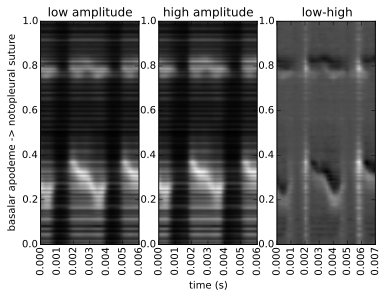

In [219]:
# plot the averages
subplot(1,3,1)
interp_0_25_img = np.mean(interp_0_25,axis =0)**1.5
imshow(interp_0_25_img,extent= ([0,0.006,0,1]),cmap = cm.gray,aspect = 'auto')
#[plot(time-time[0]+0.002,masked_rwing[trig]/np.max(masked_rwing[trig]),color = 'r',alpha = 0.1) for time,trig in zip(axon_times_0_25[:50],wtrigs_0_25[:50])]
xticks(rotation='vertical')
gca().set_title('low amplitude')
gca().set_ylabel('basalar apodeme -> notopleural suture')

subplot(1,3,2)
interp_75_100_img = np.mean(interp_75_100,axis =0)**1.5
imshow(interp_75_100_img,extent= ([0,0.006,0,1]),cmap = cm.gray,aspect = 'auto')
xticks(rotation='vertical')
gca().set_title('high amplitude')
gca().set_xlabel('time (s)')

subplot(1,3,3)
imshow(interp_0_25_img-interp_75_100_img,extent= ([0,0.007,0,1]),cmap = cm.gray,aspect = 'auto')
xticks(rotation='vertical')
gca().set_title('low-high')
#gca().set_xlabel('time (s)')
savefig('bin-wise kymo.pdf')